In [70]:
%pip install datasets transformers
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [71]:
from typing import TypedDict
import math
import os, csv

DatasetItem = TypedDict('DatasetItem', {'filename': str, 'latitude': float, 'longitude': float, 'sector': int})

files = os.listdir('./dataset/images')
files = sorted(files, key=lambda x: int(x.split('.')[0]))

with open('dataset/coords.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)   
    coords = list(reader)
    coords = [[float(lat), float(lon)] for lat, lon in coords]

def sector_from_coords(lat: float, lon: float) -> int:
    norm_lat = (lat + 90) / 180
    norm_lon = (lon + 180) / 360
    sector = math.floor(norm_lat * 10) * 36 + math.floor(norm_lon * 10)
    return sector


with open('dataset/labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'latitude', 'longitude', 'sector'])
    for file_name, coord in zip(files, coords) :
        lat, lon = coord
        sector = sector_from_coords(lat, lon)
        writer.writerow([file_name, lat, lon, sector])


Dataset({
    features: ['filename', 'latitude', 'longitude', 'sector'],
    num_rows: 9000
})


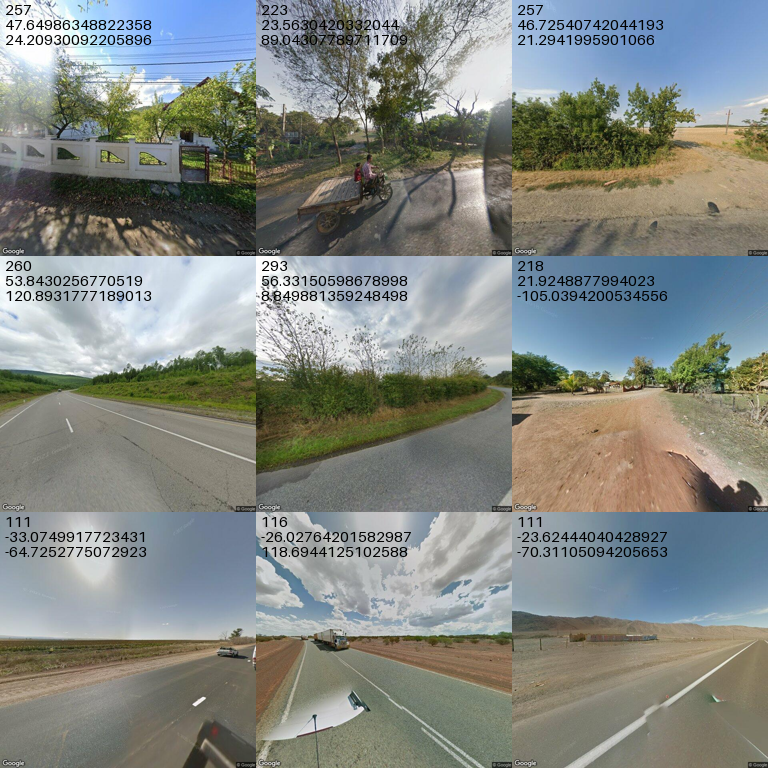

In [85]:
from datasets import load_dataset, Dataset # type: ignore
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple, Set
import random

dataset = load_dataset("csv", data_files="dataset/labels.csv", split='train').train_test_split(test_size=0.1) # type: ignore

def show_examples(train: Dataset, size: Tuple[int, int]):
    w, h = size
    print(train)
    items_in_dataset = train.num_rows
    square = 3

    keys: Set[int] = set()
    count = 0 

    grid = Image.new('RGB', size=(w * square, h * square))
    font = ImageFont.load_default(size=15)
    
    while count < square * square:
        rand = random.randrange(items_in_dataset)
        if rand in keys:
            continue
        keys.add(rand)

        item: DatasetItem = train[rand] # type: ignore
        file_name = item["filename"]
        image = Image.open(f"./dataset/images/{file_name}") # type: ignore
        x = count % square
        y = count // square
        grid.paste(image.resize((w, h)), (x * w, y * h)) # type: ignore
        draw = ImageDraw.Draw(grid) # type: ignore

        sector = item["sector"]
        lat = item["latitude"]
        lon = item["longitude"]

        draw.text((x * w + 5 , y * h), str(sector), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 15), str(lat), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 30), str(lon), font=font, fill=(0,0,0)) # type: ignore
        count += 1
        
    return grid

show_examples(dataset["train"], size=(256, 256)) # type: ignore